### Semaine 2 : CNN vs MLP sur MNIST
### Ce notebook présente le chargement de données, la définition des architectures MLP et CNN, l'entraînement, la comparaison et la visualisation.

### 1. Chargement et prétraitement des données
###  - Chargement MNIST
###  - Normalisation et reshape pour CNN (N, 1, 28, 28)
###  - One-hot encoding des labels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request, gzip, pickle, os

def load_mnist():
    url = 'https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz'
    filename = 'mnist.pkl.gz'
    if not os.path.exists(filename):
        print("Download MNIST")
        urllib.request.urlretrieve(url, filename)
    with gzip.open(filename, 'rb') as f:
        train, val, test = pickle.load(f, encoding='latin1')
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    # Normalisation
    X_train = X_train.reshape(-1,1,28,28) / 255.0
    X_val = X_val.reshape(-1,1,28,28) / 255.0
    X_test = X_test.reshape(-1,1,28,28) / 255.0
    y_train_oh = np.eye(10)[y_train.astype(int)]
    y_val_oh = np.eye(10)[y_val.astype(int)]
    y_test_oh = np.eye(10)[y_test.astype(int)]
    return (X_train, y_train, y_train_oh), (X_val, y_val, y_val_oh), (X_test, y_test, y_test_oh)

(X_train, y_train, y_train_oh), (X_val, y_val, y_val_oh), (X_test, y_test, y_test_oh) = load_mnist()
print(f"Train shape: {X_train.shape}, Valid shape: {X_val.shape}")

Train shape: (50000, 1, 28, 28), Valid shape: (10000, 1, 28, 28)


### 2. Définition des architectures MLP et CNN

In [2]:
import sys
sys.path.append('C:/Users/Alien/Desktop/cnn-from-scratch/week2-cnn-layers/src')
from layers import Dense, ReLU, Softmax, Conv2D, MaxPool2D, Flatten
from losses import CrossEntropyLoss
from optimizers import SGD, Adam
from model import Sequential

# MLP
mlp_model = Sequential([
    Flatten(),
    Dense(784, 512), ReLU(),
    Dense(512, 256), ReLU(),
    Dense(256, 10), Softmax()
])

# CNN
cnn_model = Sequential([
    Conv2D(1, 8, 3, stride=1, padding=1), ReLU(),
    MaxPool2D(2, 2),
    Conv2D(8, 16, 3, stride=1, padding=1), ReLU(),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(16*7*7, 128), ReLU(),
    Dense(128, 10), Softmax()
])

### 3. Entraînement et comparaison

In [3]:
def train(model, X_train, y_train_oh, X_val, y_val, y_val_oh, epochs=10, batch_size=64):
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(lr=0.001)
    n_batches = len(X_train) // batch_size
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        # Shuffle train
        indices = np.random.permutation(len(X_train))
        X_train_shuf = X_train[indices]
        y_train_shuf = y_train_oh[indices]

        epoch_loss = 0
        epoch_acc = 0

        for b in range(n_batches):
            start = b * batch_size
            end = start + batch_size
            X_batch = X_train_shuf[start:end]
            y_batch = y_train_shuf[start:end]

            logits = model.forward(X_batch)
            loss = loss_fn.forward(logits, y_batch)
            grad = loss_fn.backward()
            model.backward(grad)

            params = model.get_params_and_grads()
            optimizer.step(params)

            preds = np.argmax(logits, axis=1)
            labels = np.argmax(y_batch, axis=1)
            acc = np.mean(preds == labels)

            epoch_loss += loss
            epoch_acc += acc

        # Validation
        val_logits = model.forward(X_val)
        val_loss = loss_fn.forward(val_logits, y_val_oh)
        val_preds = np.argmax(val_logits, axis=1)
        val_accuracy = np.mean(val_preds == y_val)

        train_losses.append(epoch_loss / n_batches)
        train_acc.append(epoch_acc / n_batches)
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} train loss: {train_losses[-1]:.4f}, train acc: {train_acc[-1]:.4f} | val loss: {val_losses[-1]:.4f}, val acc: {val_acc[-1]:.4f}")

    return train_losses, train_acc, val_losses, val_acc

print("Training MLP...")
mlp_history = train(mlp_model, X_train, y_train_oh, X_val, y_val, y_val_oh)
print("Training CNN...")
cnn_history = train(cnn_model, X_train, y_train_oh, X_val, y_val, y_val_oh)

Training MLP...
Epoch 1/10 train loss: 0.7127, train acc: 0.7923 | val loss: 0.3420, val acc: 0.8998
Epoch 2/10 train loss: 0.3358, train acc: 0.9023 | val loss: 0.2756, val acc: 0.9220
Epoch 3/10 train loss: 0.2791, train acc: 0.9179 | val loss: 0.2333, val acc: 0.9326
Epoch 4/10 train loss: 0.2368, train acc: 0.9309 | val loss: 0.1971, val acc: 0.9451
Epoch 5/10 train loss: 0.2000, train acc: 0.9402 | val loss: 0.1803, val acc: 0.9509
Epoch 6/10 train loss: 0.1707, train acc: 0.9491 | val loss: 0.1592, val acc: 0.9538
Epoch 7/10 train loss: 0.1468, train acc: 0.9564 | val loss: 0.1370, val acc: 0.9616
Epoch 8/10 train loss: 0.1266, train acc: 0.9622 | val loss: 0.1260, val acc: 0.9634
Epoch 9/10 train loss: 0.1113, train acc: 0.9665 | val loss: 0.1159, val acc: 0.9673
Epoch 10/10 train loss: 0.0983, train acc: 0.9706 | val loss: 0.1046, val acc: 0.9692
Training CNN...
Epoch 1/10 train loss: 0.8312, train acc: 0.7505 | val loss: 0.3304, val acc: 0.8994
Epoch 2/10 train loss: 0.3032, t

### 4. Visualisation des courbes d'entraînement

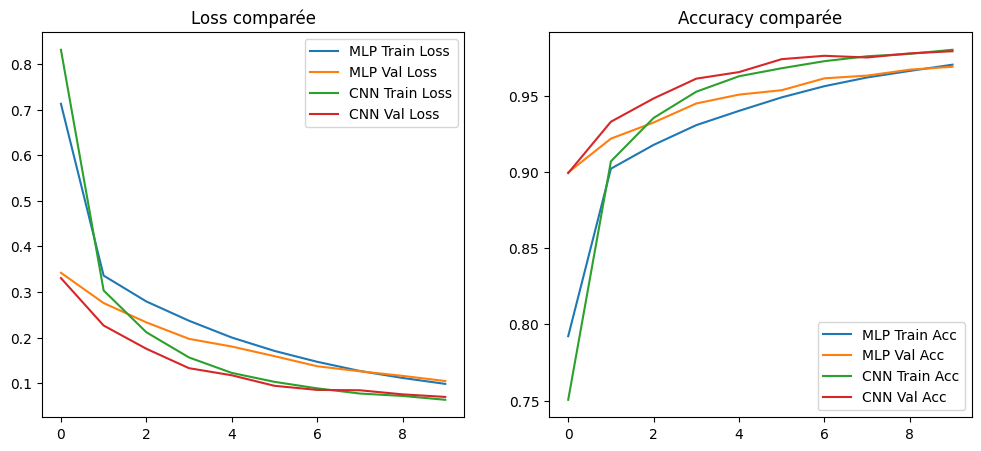

In [4]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(mlp_history[0], label='MLP Train Loss')
plt.plot(mlp_history[2], label='MLP Val Loss')
plt.plot(cnn_history[0], label='CNN Train Loss')
plt.plot(cnn_history[2], label='CNN Val Loss')
plt.legend()
plt.title('Loss comparée')

plt.subplot(1,2,2)
plt.plot(mlp_history[1], label='MLP Train Acc')
plt.plot(mlp_history[3], label='MLP Val Acc')
plt.plot(cnn_history[1], label='CNN Train Acc')
plt.plot(cnn_history[3], label='CNN Val Acc')
plt.legend()
plt.title('Accuracy comparée')

plt.show()

### 5. Visualisation des Feature Maps et Filtres CNN (première couche)

Filtres CNN première couche :


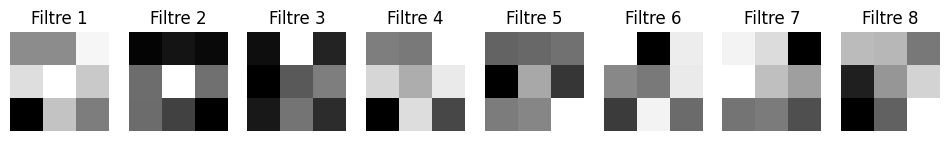

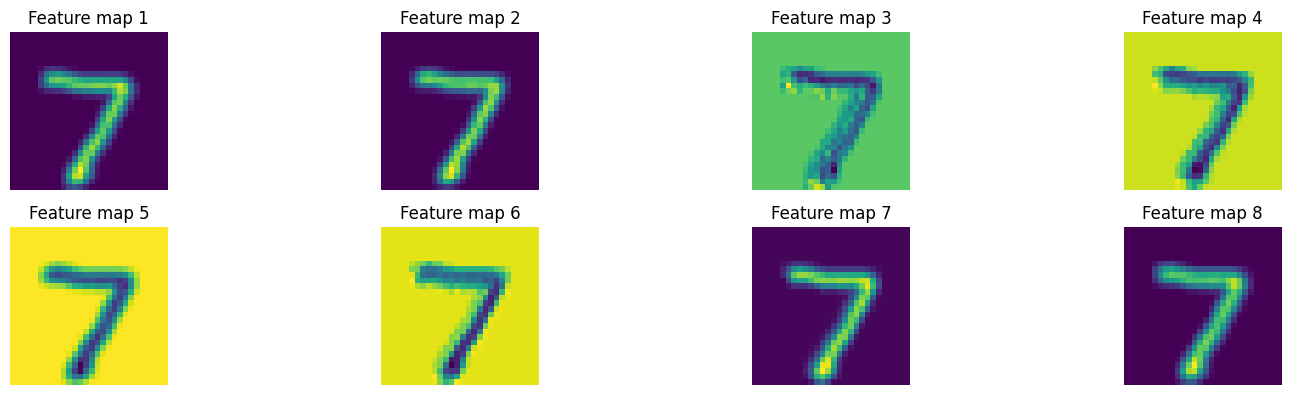

In [5]:
def plot_filters(W):
    n_filters = W.shape[0]
    plt.figure(figsize=(12,3))
    for i in range(n_filters):
        plt.subplot(1, n_filters, i+1)
        filt = W[i, 0]
        plt.imshow(filt, cmap='gray')
        plt.axis('off')
        plt.title(f'Filtre {i+1}')
    plt.show()

print("Filtres CNN première couche :")
plot_filters(cnn_model.layers[0].W)

def visualize_feature_maps(model, layer_idx, input_image):
    x = input_image
    for idx, layer in enumerate(model.layers):
        x = layer.forward(x)
        if idx == layer_idx:
            feature_maps = x
            break
    n_maps = feature_maps.shape[1]
    plt.figure(figsize=(15, int(n_maps/4)*3))
    for i in range(n_maps):
        plt.subplot(n_maps//4 +1, 4, i+1)
        fmap = feature_maps[0,i]
        plt.imshow(fmap, cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature map {i+1}')
    plt.tight_layout()
    plt.show()

# Choisir une image test (reshape 1,1,28,28)
sample_img = X_test[0:1]
visualize_feature_maps(cnn_model, 0, sample_img)